#  CREDIT CARD FRAUD ANALYSIS

## PART 2 : Handling Class Imbalance 

### Imports 

In [1]:

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")



### Data Reads 

In [2]:
df = pd.read_csv('creditcard_data.csv')

## PART 2 :  Handling Class Imbalance 

### Check for class imbalance 

In [3]:
# Check for class Imbalance 

# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

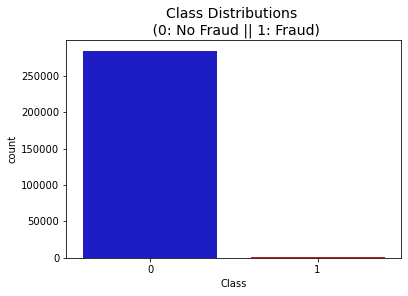

In [4]:
# Check Visual for the class distribution 

colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

### Check distribution for Amount and Time field 

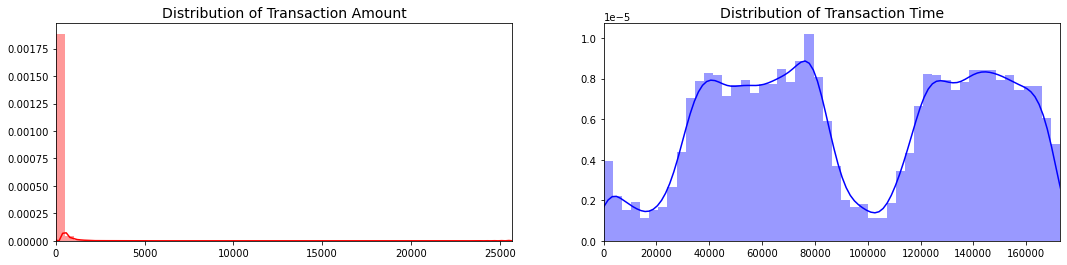

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

*Observation* : Most of the Transactions are smaller amount :  The ferquency of Transactions have a clear peak pattern depending upon the time of the day 

### Scale Variables Time and Amount 

In [6]:
# Scale using Robust scaler as it is less prone to outliers 

# Scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

#std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783399,-0.994981
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269843,-0.994981
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.984069,-0.994969
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418390,-0.994969
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670626,-0.994957


### Split original  data set for testing 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


# Create X an y Data 
X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284803 284804 284805] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284803 284804 284805] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284803 284804 284805] Test: [ 81186  81609  82400 ... 170946 170947 170948]
Train: [     0      1      2 ... 284803 284804 284805] Test: [150647 150654 150660 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [208651 212516 212644 ... 284803 284804 284805]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827514 0.00172486]
[0.99826197 0.00173803]


## CLASS IMBALANCE HANDLING APPROACHES 

### 1. Random Undersampling

#### Steps:
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 492 non-fraud transaction  from 284,315 non-fraud transaction)

In [8]:
# Create Undersample and Equally represented dataset 
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

# combine the fraud and non fraud rows 
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
260781,-1.164409,-1.279381,-1.304220,-1.200687,-0.779834,0.229462,0.985915,0.047662,0.735229,-1.138166,...,1.261114,0.322502,0.190814,-2.103252,0.395667,0.367545,0.025671,0,5.519843,0.881504
154720,-5.552122,5.678134,-9.775528,8.416295,-4.409844,-1.506235,-6.899839,3.750443,-3.879793,-6.864164,...,0.228484,0.286258,-0.536294,-0.104925,0.420919,-0.297557,-0.946184,1,1.365847,0.211287
108353,0.826988,-0.317576,0.261861,1.125783,-0.209647,0.191533,0.100275,0.144713,-0.171466,0.083819,...,-0.930181,0.000403,-0.370508,0.133099,-0.695116,0.000863,0.043726,0,2.133035,-0.162520
151006,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,-22.187089,...,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1,-0.293460,0.113612
163586,0.949241,1.333519,-4.855402,1.835006,-1.053245,-2.562826,-2.286986,0.260906,-0.895366,-4.542612,...,-0.854627,0.101177,-0.281497,0.024444,-0.107944,0.625289,0.315677,1,0.600894,0.368609


### Undersampling using imblearn
TBD 

**Check for class distribution after Under Sampling**

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


Text(0.5, 1.0, 'After')

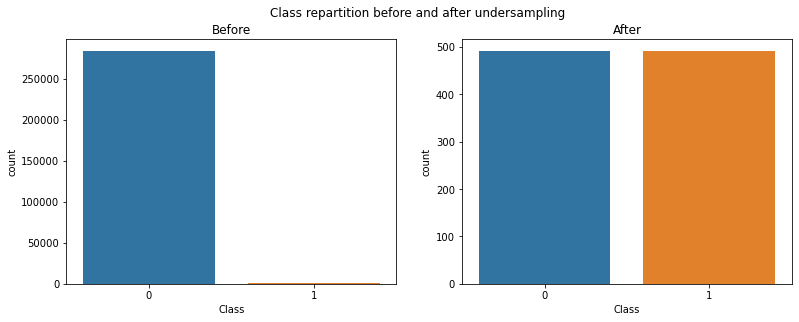

In [9]:
# Check class distribution after undersampling 
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))


#visualizing undersampling results
fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sns.countplot(x="Class", data=df, ax=axs[0])
sns.countplot(x="Class", data=new_df, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

#### Check correlation matrix with balanced data set 
https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

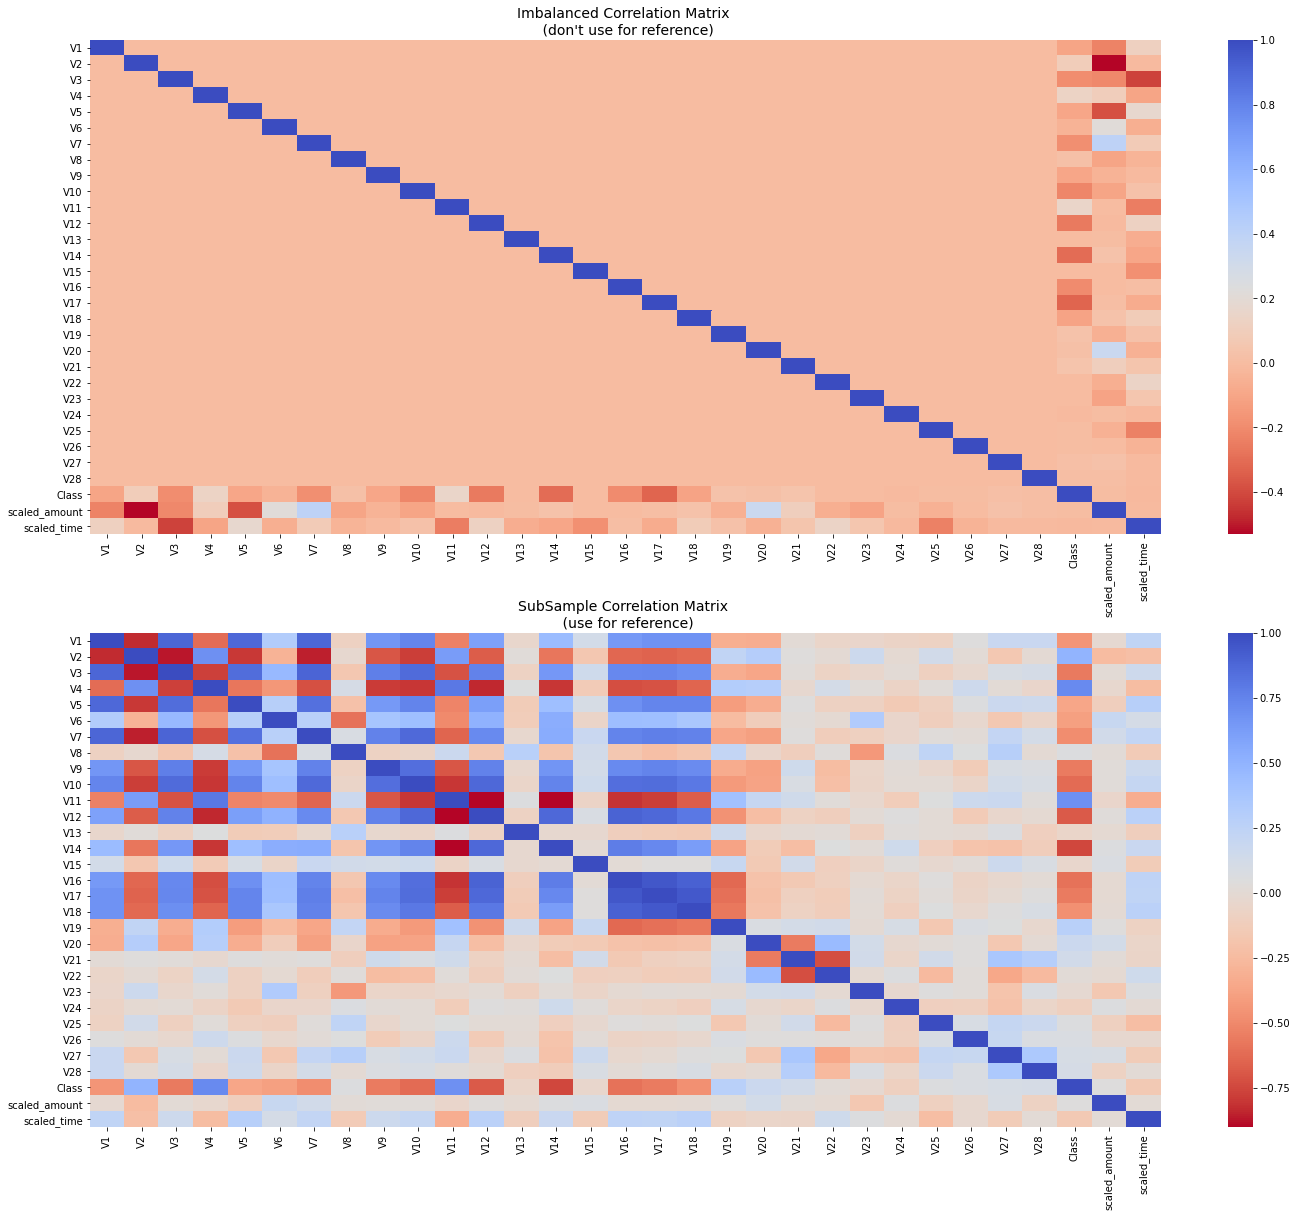

In [10]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

#. Balanced Sub Set 
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

### Observations from the Reference Heatmap 

**Positive correlation with Y Variable**
V2 ;V4; V11 ; V19 


**Negative correlation with Y Variable**
V17, V16, V14, V12 and V10 

### Box plots to Study Distributions by class for Highly correlated variables 



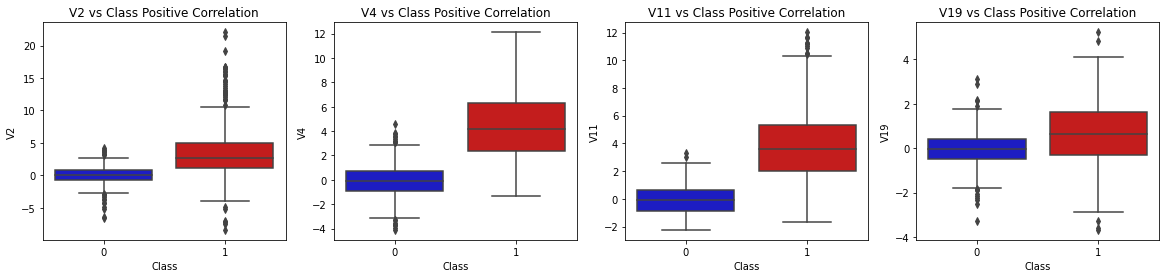

In [11]:
## Positively correlated variables 
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V11 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

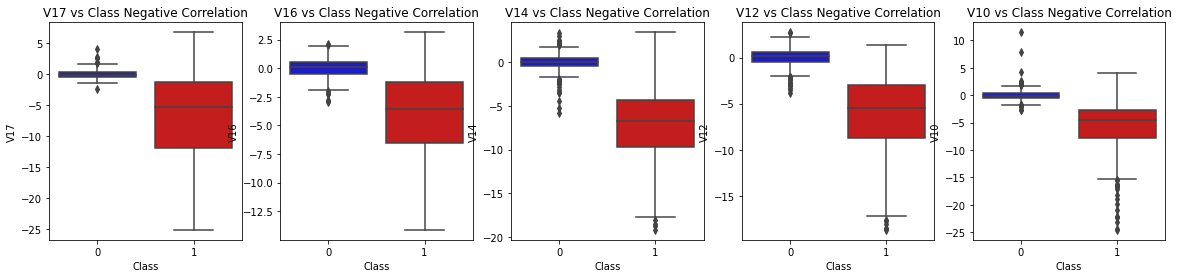

In [12]:
## Negatively correlated variables 
#----------------------------------
# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)

f, axes = plt.subplots(ncols=5, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V16 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[4])
axes[4].set_title('V10 vs Class Negative Correlation')

plt.show()

**Observation :**.  For the variable studied the low values clearly result in fraud 

###  Visualize and remove extreme outliers for high correlated variables 


#### Steps:
<ul>
<li> <b> Visualize Distributions: </b> We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. </li>
<li><b>Determining the threshold: </b> After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold). </li>
<li> <b>Conditional Dropping: </b> Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed. </li>
<li> <b> Boxplot Representation: </b> Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount. </li>
</ul>

####  Visualize the Top Negative correlated Variables with Y 
V10, V12 , V14 

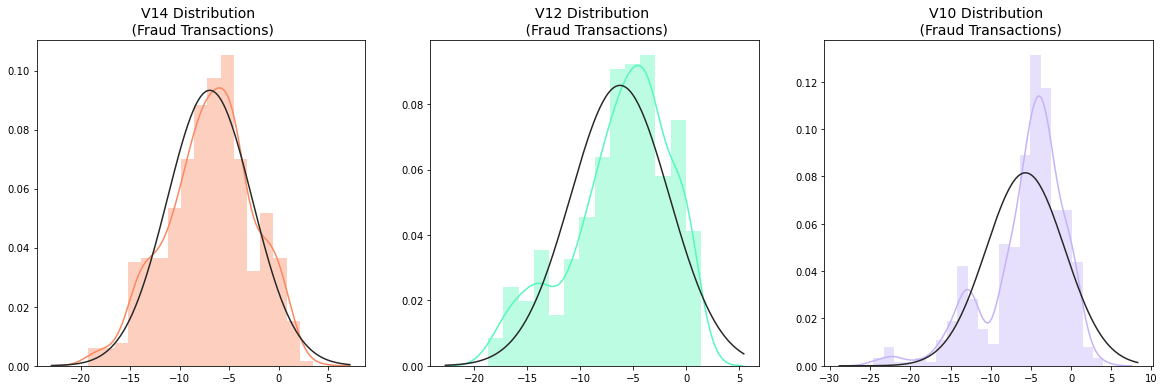

In [13]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [14]:
#### Observations :

### Visualize the Top positive correlated variables  with Y
V2,V4,V11 

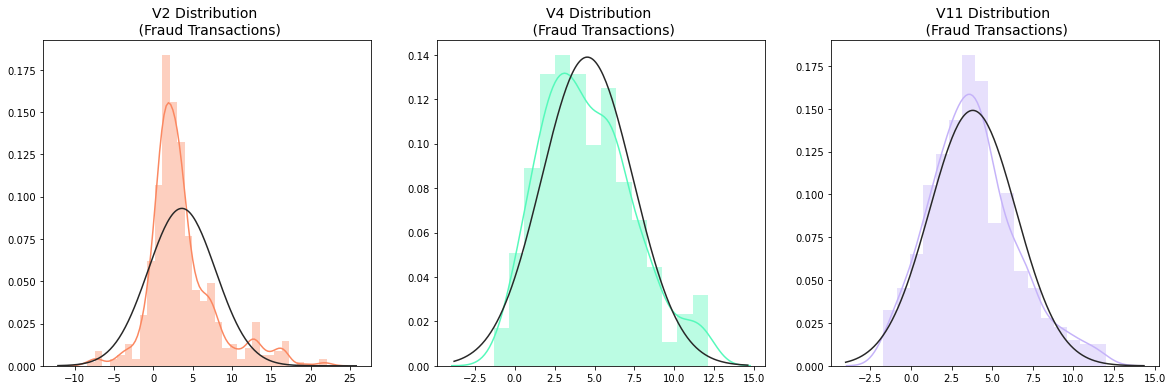

In [15]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

### Remove Extreme Outliers From Negative correlated variables 

**Remove outliers from V14**

In [16]:
 # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
# Isolate the fraud rows     
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values

# Get the lower quartile and upper quartile 
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

# Get the interquartile range 
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

# define cut offs 
v14_cut_off = v14_iqr * 1.5

# define lower and upper cut offs 
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

# Get the outliers for Fraud Rows 
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))


# Drop outliers from Fraud rows 
print("row count before outlier drop : {}".format(new_df.shape[0]))
new_df = new_df.drop(new_df[((new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower))&(new_df['Class'] ==1 )].index)
print("row count after outlier drop : {}".format(new_df.shape[0]))
print('----' * 44)

Quartile 25: -9.69272296475 | Quartile 75: -4.2828208495
iqr: 5.40990211525
Cut Off: 8.114853172875002
V14 Lower: -17.807576137625002
V14 Upper: 3.8320323233750013
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-18.49377336, -18.04999769, -18.82208674, -19.21432549]
row count before outlier drop : 984
row count after outlier drop : 980
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#### Remove outliers from V12 

In [17]:
# -----> V12 Removing Outliers (Highest Negative Correlated with Labels)
# Isolate the fraud rows     
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values

# Get the lower quartile and upper quartile 
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

# Get the interquartile range 
v12_iqr = q75 - q25
print('iqr: {}'.format(v12_iqr))

# define cut offs 
v12_cut_off = v12_iqr * 1.5

# define lower and upper cut offs 
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Cut Off: {}'.format(v12_cut_off))
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))

# Get the outliers for Fraud Rows 
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V12 outliers:{}'.format(outliers))


# Drop outliers from Fraud rows 
print("row count before outlier drop : {}".format(new_df.shape[0]))
new_df = new_df.drop(new_df[((new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower))&(new_df['Class'] ==1 )].index)
print("row count after outlier drop : {}".format(new_df.shape[0]))
print('----' * 44)

Quartile 25: -8.6730332045 | Quartile 75: -2.8930305682500004
iqr: 5.780002636249999
Cut Off: 8.670003954374998
V12 Lower: -17.343037158875
V12 Upper: 5.776973386124998
Feature V12 Outliers for Fraud Cases: 4
V12 outliers:[-18.43113103, -18.55369701, -18.68371463, -18.04759657]
row count before outlier drop : 980
row count after outlier drop : 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [18]:
#### Remove Outliers from V10 

# -----> V10 Removing Outliers (Highest Negative Correlated with Labels)
# Isolate the fraud rows     
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values

# Get the lower quartile and upper quartile 
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

# Get the interquartile range 
v10_iqr = q75 - q25
print('iqr: {}'.format(v10_iqr))

# define cut offs 
v10_cut_off = v10_iqr * 1.5

# define lower and upper cut offs 
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Cut Off: {}'.format(v10_cut_off))
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))

# Get the outliers for Fraud Rows 
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))


# Drop outliers from Fraud rows 
print("row count before outlier drop : {}".format(new_df.shape[0]))
new_df = new_df.drop(new_df[((new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower))&(new_df['Class'] ==1 )].index)
print("row count after outlier drop : {}".format(new_df.shape[0]))
print('----' * 44)

Quartile 25: -7.466658536000001 | Quartile 75: -2.51186113825
iqr: 4.954797397750001
Cut Off: 7.432196096625002
V10 Lower: -14.898854632625003
V10 Upper: 4.920334958375001
Feature V10 Outliers for Fraud Cases: 27
V10 outliers:[-22.18708856, -15.23996196, -16.60119697, -15.12416281, -19.83614885, -24.58826244, -15.34609885, -14.92465477, -16.64962816, -15.56379134, -16.30353766, -22.18708856, -22.18708856, -15.23183337, -16.74604411, -20.94919155, -24.40318497, -16.25561175, -23.22825484, -18.91324333, -15.23996196, -22.18708856, -17.14151364, -15.56379134, -14.92465477, -15.12375218, -18.27116817]
row count before outlier drop : 976
row count after outlier drop : 949
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### Removing Extreme Outliers from Highly Positive correlated variables 


#### Remove Outliers from V2 

In [19]:
#### Remove Outliers from V2 

# -----> V2 Removing Outliers (Highest Negative Correlated with Labels)
# Isolate the fraud rows     
v2_fraud = new_df['V2'].loc[new_df['Class'] == 1].values

# Get the lower quartile and upper quartile 
q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

# Get the interquartile range 
v2_iqr = q75 - q25
print('iqr: {}'.format(v2_iqr))

# define cut offs 
v2_cut_off = v2_iqr * 1.5

# define lower and upper cut offs 
v2_lower, v2_upper = q25 - v2_cut_off, q75 + v2_cut_off
print('Cut Off: {}'.format(v2_cut_off))
print('V2 Lower: {}'.format(v2_lower))
print('V2 Upper: {}'.format(v2_upper))

# Get the outliers for Fraud Rows 
outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
print('Feature V2 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V2 outliers:{}'.format(outliers))


# Drop outliers from Fraud rows 
print("row count before outlier drop : {}".format(new_df.shape[0]))
new_df = new_df.drop(new_df[((new_df['V2'] > v2_upper) | (new_df['V2'] < v2_lower))&(new_df['Class'] ==1 )].index)
print("row count after outlier drop : {}".format(new_df.shape[0]))
print('----' * 44)

Quartile 25: 1.133138588 | Quartile 75: 4.141986232
iqr: 3.008847644
Cut Off: 4.513271466
V2 Lower: -3.380132878
V2 Upper: 8.655257698
Feature V2 Outliers for Fraud Cases: 46
V2 outliers:[12.78597064, 13.76594216, 14.60199804, 10.5417508, -3.9359189239999997, 16.15570143, 10.39391714, 12.65219683, 12.37398914, 12.78597064, 15.59819266, 12.78597064, 12.78597064, 9.067613427000001, -4.81446074, 12.78597064, -7.159041717000001, -6.976420008, 12.78597064, 11.81792199, 11.58638052, 12.09589323, 14.32325381, -3.4204679839999996, 12.93050512, -7.1969796310000005, -8.402153678, 14.04456678, 8.775997152999999, 10.11481572, -7.449015159, 10.81966537, -5.198360199, 13.20890428, 16.43452455, 16.71338924, 8.713250171, 9.669900173, -3.4881301810000003, 13.48738579, 15.87692299, 10.55860019, 9.223691949, 15.36580438, -3.9523200860000003, -3.930731396]
row count before outlier drop : 949
row count after outlier drop : 903
--------------------------------------------------------------------------------

#### Remove Outliers for V11

In [20]:

# -----> V11 Removing Outliers (Highest Negative Correlated with Labels)
# Isolate the fraud rows     
v11_fraud = new_df['V11'].loc[new_df['Class'] == 1].values

# Get the lower quartile and upper quartile 
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

# Get the interquartile range 
v11_iqr = q75 - q25
print('iqr: {}'.format(v11_iqr))

# define cut offs 
v11_cut_off = v11_iqr * 1.5

# define lower and upper cut offs 
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print('Cut Off: {}'.format(v11_cut_off))
print('V11 Lower: {}'.format(v11_lower))
print('V11 Upper: {}'.format(v11_upper))

# Get the outliers for Fraud Rows 
outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V11 outliers:{}'.format(outliers))


# Drop outliers from Fraud rows 
print("row count before outlier drop : {}".format(new_df.shape[0]))
new_df = new_df.drop(new_df[((new_df['V11'] > v11_upper) | (new_df['V11'] < v11_lower))&(new_df['Class'] ==1 )].index)
print("row count after outlier drop : {}".format(new_df.shape[0]))
print('----' * 44)

Quartile 25: 1.8450858435 | Quartile 75: 4.775434035
iqr: 2.9303481915000003
Cut Off: 4.39552228725
V11 Lower: -2.5504364437500007
V11 Upper: 9.17095632225
Feature V11 Outliers for Fraud Cases: 11
V11 outliers:[9.369079057999999, 11.27792073, 10.27776886, 10.18758732, 9.939819742000001, 10.54526295, 11.1524906, 10.06378975, 9.328799257, 10.85301165, 10.44684681]
row count before outlier drop : 903
row count after outlier drop : 892
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### Check outlier removal with Box Plots 

#### Box plots for highly correlated -ve features :  V10, V12 , V14

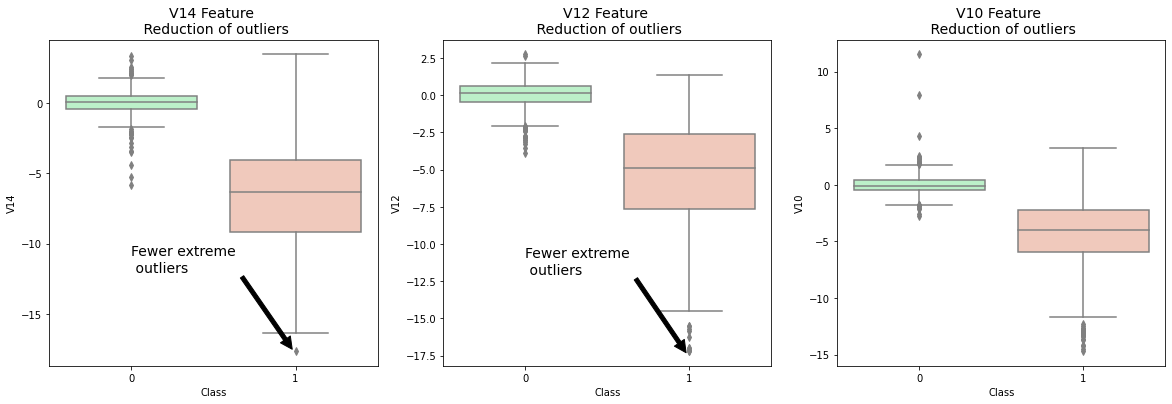

In [21]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

#### Box plots for highly correlated +ve features : V2, V4, V11 

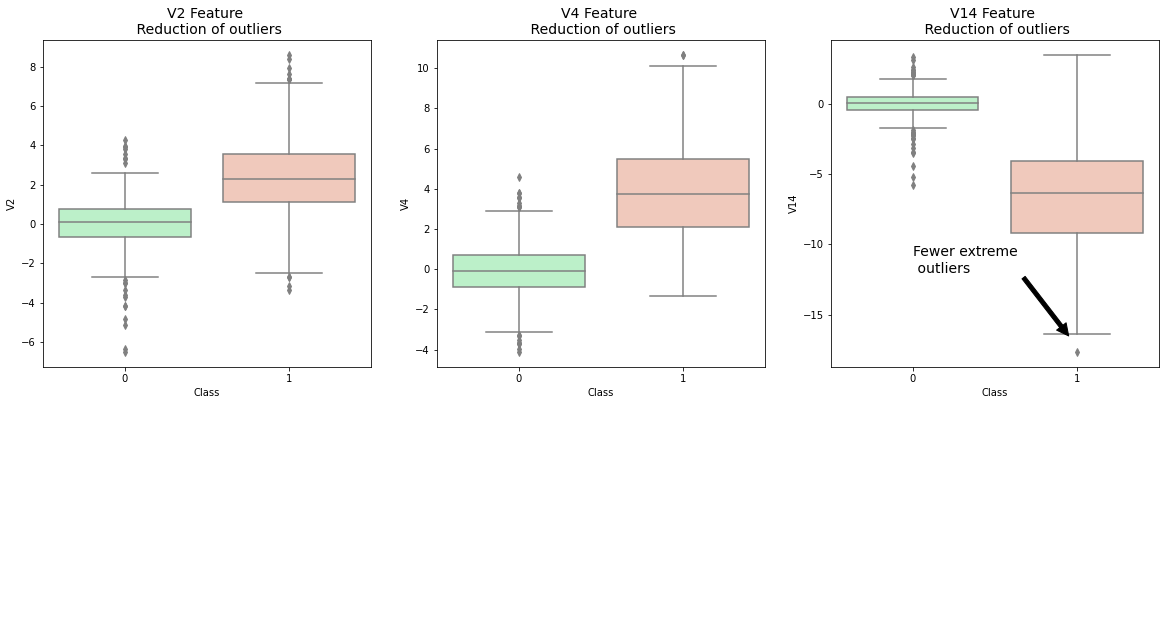

In [22]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V2
sns.boxplot(x="Class", y="V2", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V2 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V4", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V4 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V14", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

### Dimensionality Reduction and Clustering Visualization using t-SNE 

<h3> Summary: </h3>
<ul> 
<li>t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset. </li>
<li> Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)</li>
<li> This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases. </li>
</ul>

In [23]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 2.2 s
PCA took 0.018 s
Truncated SVD took 0.0034 s


### Plot Scatter from the various reduced techniques 

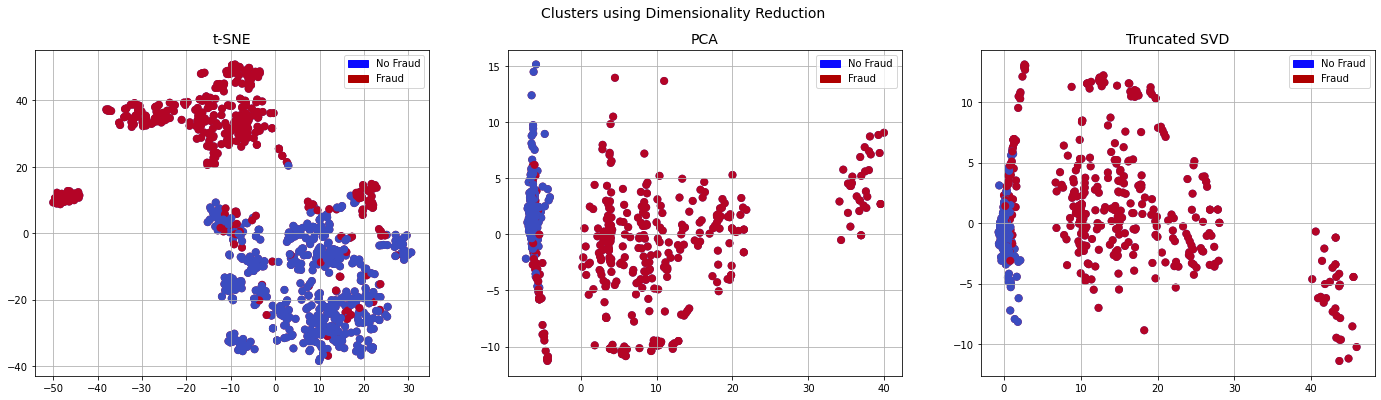

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

#### Observations : We find that t-SNE offers a good separation -  Thus the classes are separable 

## Classification with - Under Sampling 

In [25]:
# Preparing data for modelling 
#----------------------------

# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_train1 = X_train.values
X_train1.shape

(713, 30)

In [27]:
# Let's implement simple classifiers

classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SupportVectorClassifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

####  Cross Validation employed 

In [28]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 89.0 % accuracy score


**Observation** 

LR has the best training accuracy with CV 

#### Grid Search Employed - Hyperparameter tuned individually for  each classifiers 

In [29]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
#-----------------------------------
# penalty is regularization L1 or L2 
# C parameter inverse of Reg strength 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_
#--------------------------------------

# K nearest neighbours 
#-----------------------------------
# Number of nearest neighbours
# Algo to find distance 
# auto
# ball_tree
# kd_tree
# brute 
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
#----------------------------------------------

# Support Vector Classifier
#----------------------------------------
# Small value of C will cause the optimizer to look for alarger margin hence more misclassification 
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_
#---------------------------------------


# DecisionTree Classifier
#--------------------------------------
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# tree best estimator
tree_clf = grid_tree.best_estimator_
#-------------------------------------

#### Get the Cross Validated Score for each of the best models chosen 


In [30]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.41%
Knears Neighbors Cross Validation Score 93.69%
Support Vector Classifier Cross Validation Score 93.27%
DecisionTree Classifier Cross Validation Score 92.56%


#### Get the ROC Score for All the models 

In [31]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Capture the predictions from all the models 

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [32]:
# Get the ROC Score for all the models 

from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9801644202275117
KNears Neighbors:  0.9331126724659847
Support Vector Classifier:  0.9799095051460982
Decision Tree Classifier:  0.9220756460504095


**Observation** Logistics Regression shows the best ROC Score 

### Plot ROC Curve 

In [33]:
# Get ROC curve parms for Logit 
log_fpr, log_tpr, log_threshold = roc_curve(y_train, log_reg_pred)

# Get ROC curve parms for Logit 
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)

# Get ROC curve parms for Logit 
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)

# Get ROC curve parms for Logit 
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)

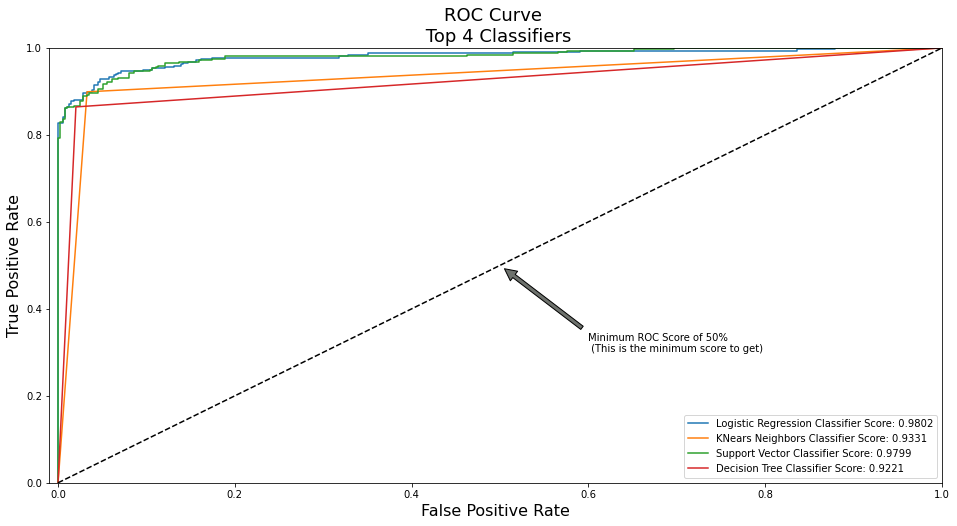

In [34]:
# plot curve 


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

In [59]:
labels = ['No Fraud', 'Fraud']
undersample_pred = log_reg.predict(original_Xtest)
print(classification_report(original_ytest, undersample_pred, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      1.00     56862
       Fraud       0.15      0.88      0.26        99

    accuracy                           0.99     56961
   macro avg       0.57      0.94      0.63     56961
weighted avg       1.00      0.99      0.99     56961



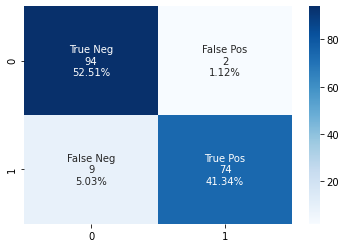

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns 

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg.predict(X_test)

# Confusion Matrix 
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in log_reg_cf.flatten()]
                
group_percentages = ["{0:.2%}".format(value) for value in
                     log_reg_cf.flatten()/np.sum(log_reg_cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)



sns.heatmap(log_reg_cf, annot=labels, fmt='', cmap='Blues')


## Classification with Over Sampling 

### SMOTE Technique (Over-Sampling):
<a id="smote"></a>
<img src="https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png", width=800>
<b>SMOTE</b> stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br><br>


<b> Understanding SMOTE: </b>
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy || Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

</ul>

### Cautionary Note on Cross Validation for SMOTE 


## Overfitting during Cross Validation:  

### The Wrong Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"><br>

As mentioned previously, if we get the minority class ("Fraud) in our case, and create the synthetic points before cross validating we have a certain influence on the "validation set" of the cross validation process. Remember how cross validation works, let's assume we are splitting the data into 5 batches, 4/5 of the dataset will be the training set while 1/5 will be the validation set. The test set should not be touched! For that reason, we have to do the creation of synthetic datapoints "during" cross-validation and not before, just like below: <br>


### The Right Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>
As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.




**References**: 
<ul>
<li><a src="https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation"> 
DEALING WITH IMBALANCED DATA: UNDERSAMPLING, OVERSAMPLING AND PROPER CROSS-VALIDATION </a></li> 

<li> <a src="http://rikunert.com/SMOTE_explained "> SMOTE explained for noobs  </a></li>
<li> <a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s"> Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a></li>
</ul>

## SMOTE Implementation for OverSampling with CV for Logistics Regression 

### MODEL TRAIN 

In [35]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Instantiate LR 
log_reg_sm = LogisticRegression()

# LR parameters 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Instantiate Random Search CV 
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

# Implementing SMOTE Technique 
# Cross Validating the right way

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
# Get the MEAN Values of the CV accuracies 
#-------------------------------------------------------
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9425706072110426
precision: 0.0622266391310668
recall: 0.9137617656604998
f1: 0.11454090998118364
---------------------------------------------------------------------------------------------------------------------------------------


### MODEL TEST 

**Classification report on test data**

In [36]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56862
       Fraud       0.10      0.86      0.18        99

    accuracy                           0.99     56961
   macro avg       0.55      0.92      0.58     56961
weighted avg       1.00      0.99      0.99     56961



**Precision and Recall Studies**

In [37]:
from sklearn.metrics import average_precision_score
y_score = best_est.decision_function(original_Xtest)
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.70


**Plot Precision Recall Curve**

Text(0.5, 1.0, 'Precision-Recall curve: \n Average Precision-Recall Score =0.70')

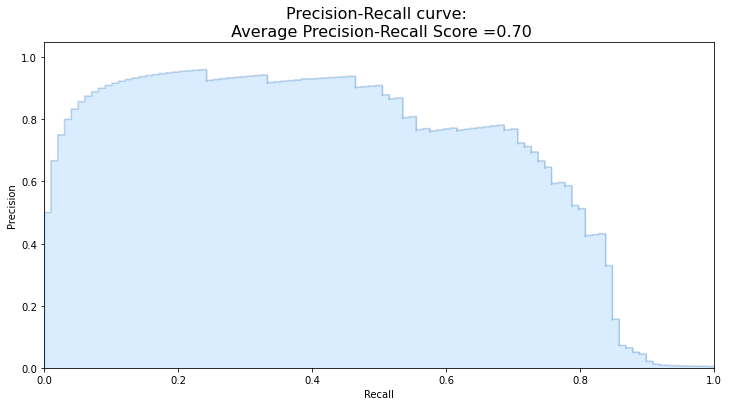

In [38]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

**Confusion Matrix**

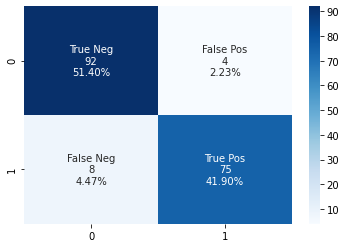

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns 

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = best_est.predict(X_test)

# Confusion Matrix 
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in log_reg_cf.flatten()]
                
group_percentages = ["{0:.2%}".format(value) for value in
                     log_reg_cf.flatten()/np.sum(log_reg_cf)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)



sns.heatmap(log_reg_cf, annot=labels, fmt='', cmap='Blues')
